<div align="right"><h8><i>Cristina Cristalli - 838022<br>
Francesca Franzese - 847780<br>
    Alessia Petescia - 839141</i><br><br>
    <b>Progetto Digital Signal and Image Management - Punto 1<br>
        CdL Data Science 2020</b></h8></div>

## 1. Speaker recognition

<b>Task: </b> Speaker recognition.
<br><br>
Audio files were recorded  <b><i>with no bound on the senteces told. Each file has a duration of 5s</i></b>.
<p>The notebook is organized as follows:</p>
<ol>
<li><i>Loading of audio files and feature extraction:</i> the following features were implemented: 
<ul style="list-style-type:circle">
<li>Zero Crossing Rate</li>
<li>Eneregy</li> 
<li>Duration</li> 
<li>Average</li>
<li>Average with absolute values</li>
<li>Standard Deviation</li>
</ul>
<br>
All the experiments were reapeated with the addiction of the <b> Mel-frequency cepstrum coefficients</b>, in order to study its effect on perfomances.
</li> 
<br>
<li><i>Models training: </i> Models hyperparameters were choosen by using the Grid Search and the Random search. The implemented models are:
<ul style="list-style-type:square">
<li>Random Forest</li>
<li>Support vector Machine</li>
<li>Neural Network</li>
</ul> </li>


In [1]:
import os
import librosa
import numpy as np
from time import time
from scipy.io import wavfile as wav
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import IPython.display as ipd
import joblib

# Classification instruments
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.utils import shuffle

#keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier 

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

<h2>Without MFCC</h2>

<h3>Audio loading and feature extraction</h3>

In [77]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    for f in sorted(os.listdir('./AUDIO')):
        #print(f)
        if f.endswith('.wav'):
            
            # Carica file ed estraine le features
            _, signal = wav.read('./AUDIO/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(int(label))

            
    features, labels = shuffle(features, labels)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
    labels=np.array(labels)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
        
        X_train = np.array(X_train)
        X_test= np.array(X_test)

    return X_train, X_test, y_train, y_test, X_train_mean, X_train_std

In [78]:
# Features functions 

def sdev(input):
    return np.std(input, keepdims=True)

def avg(input):
    return np.mean(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

def duration(input):
    return input.shape

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def zcr(input):
    return np.array([np.nonzero(np.diff(input>0))[0].size])

In [79]:
def combo(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input), zcr(input))) 

In [80]:
# data loading
X_train, X_test, y_train, y_test, X_train_mean, X_train_std = load_data(feature_extractor=combo)

In [81]:
len(X_train)

210

<h3>Classificazione</h3>

<h3>Random forest</h3>

In [82]:
# Hyperparameters to test with cross validation
param_grid_rf = {'n_estimators': [1, 4, 8, 12, 16, 20],
                 'criterion': ['entropy', 'gini'], }

clf_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf)

clf_rf = clf_rf.fit(X_train, y_train)

In [83]:
# Results for best hyperparameters
print("Best parameters:")
print(" n_estimators: "+str(clf_rf.best_estimator_.n_estimators))
print(" criterion: "+str(clf_rf.best_estimator_.criterion))

Migliore combinazione di parametri:
 n_estimators: 8
 criterion: gini


In [84]:
clf_rf_pred = clf_rf.predict(X_test) 

In [85]:
print(classification_report(y_test, clf_rf_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.75      0.79      0.77        34
           2       1.00      1.00      1.00        24

   micro avg       0.82      0.82      0.82        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.82      0.82      0.82        90



[[23  9  0]
 [ 7 27  0]
 [ 0  0 24]]


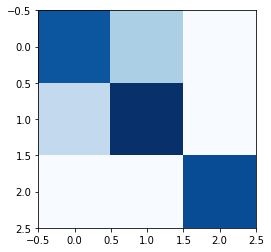

In [86]:
cm = confusion_matrix(y_test, clf_rf_pred)   
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [87]:
print(accuracy_score(y_test, clf_rf_pred))

0.8222222222222222


<h3>Support Vector Machine</h3>

In [88]:
# Hyperparameters to try
param_grid_svc = {'C': [10, 50, 100, 150, 1000],
                  'gamma': [0.005, 0.001, 0.01, 0.5],
                  'kernel': ['linear', 'rbf', 'poly']}

clf_svc = GridSearchCV(SVC(class_weight='balanced'), param_grid_svc, cv=3)

clf_svc = clf_svc.fit(X_train, y_train)

In [89]:
# Optimization results
print("Best parameters:")
print(" C: "+str(clf_svc.best_estimator_.C))
print(" gamma: "+str(clf_svc.best_estimator_.gamma))
print(" kernel: "+str(clf_svc.best_estimator_.kernel))

Best parameters:
 C: 100
 gamma: 0.005
 kernel: rbf


In [90]:
clf_svc_pred = clf_svc.predict(X_test)

In [91]:
print(classification_report(y_test, clf_svc_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.75      0.79      0.77        34
           2       1.00      1.00      1.00        24

   micro avg       0.82      0.82      0.82        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.82      0.82      0.82        90



[[23  9  0]
 [ 7 27  0]
 [ 0  0 24]]


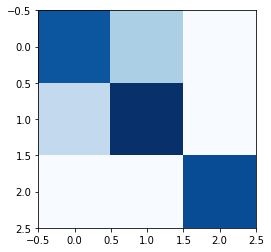

In [92]:
cm = confusion_matrix(y_test, clf_svc_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [93]:
print(accuracy_score(y_test, clf_svc_pred))

0.8222222222222222


<h3>Neural network</h3>

In [94]:
np.shape(X_train)

(210, 5)

In [95]:
def NN_model(optimizer='adam', activation_layer_1 ='softmax',activation_layer_2 ='softmax', activation_last_layer = 'softmax',  neurons = 1, dropout_rate_1 = 0.0, dropout_rate_2 = 0.0):

    modello= Sequential()
    modello.add(Dense(neurons, activation='relu', input_shape=(5,)))
    modello.add(Dropout(dropout_rate_1))
    modello.add(Dense(neurons, activation=activation_layer_1))
    modello.add(Dropout(dropout_rate_2))
    modello.add(Dense(neurons, activation=activation_layer_2))
    modello.add(Dense(3, activation = activation_last_layer))
    modello.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    return(modello)

In [96]:
modello_per_random_search = KerasClassifier(build_fn=NN_model, verbose = 0)
batch_size = [10,25,50]
epochs = [3,5,10]
optimizer = ['Adadelta', 'Adam']
activation_layer_1 = ['softmax','relu', 'sigmoid', 'tanh']
activation_layer_2 = ['softmax','relu', 'sigmoid', 'tanh']
activation_last_layer = ['softmax','relu', 'sigmoid', 'tanh']
neurons = [256,512,1024]
dropout_rate_1 = [0.0, 0.1, 0.2,0.4,0.6,0.8]
dropout_rate_2 = [0.0, 0.1, 0.2,0.4,0.6,0.8]
param_distributions = dict(batch_size=batch_size, epochs=epochs,optimizer = optimizer,
                           dropout_rate_1 = dropout_rate_1,
                           dropout_rate_2 = dropout_rate_2,
                           activation_layer_1=activation_layer_1, 
                           activation_layer_2=activation_layer_2,
                           neurons = neurons,
                           activation_last_layer = activation_last_layer)

random_search = RandomizedSearchCV(estimator=modello_per_random_search, param_distributions=param_distributions, n_iter=5)
network_history = random_search.fit(X_train, y_train)

In [97]:
network_history.best_params_

{'optimizer': 'Adam',
 'neurons': 512,
 'epochs': 10,
 'dropout_rate_2': 0.1,
 'dropout_rate_1': 0.0,
 'batch_size': 25,
 'activation_layer_2': 'softmax',
 'activation_layer_1': 'relu',
 'activation_last_layer': 'softmax'}

In [98]:
predictions = network_history.predict(X_test)

[[21 11  0]
 [ 5 29  0]
 [ 0  0 24]]


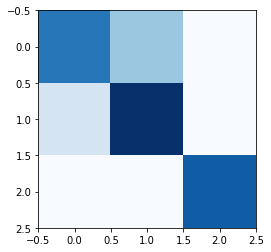

In [99]:
cm = confusion_matrix(y_test, predictions)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [100]:
print(accuracy_score(y_test, predictions))

0.8222222222222222


<h2>Utilizzando la MFCC</h2>

<h3>Data loading and feature extraction</h3>

In [101]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    for f in sorted(os.listdir('./AUDIO')):
        if f.endswith('.wav'):
            
            # Load files and extract features
            _, signal = wav.read('./AUDIO/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # labels
            label = f.split('_')[0]
            labels.append(int(label))

            
    features, labels = shuffle(features, labels)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
    labels=np.array(labels)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
        
        X_train = np.array(X_train)
        X_test= np.array(X_test)

    return X_train, X_test, y_train, y_test, X_train_mean, X_train_std

In [102]:
# Features functions 

def sdev(input):
    return np.std(input, keepdims=True)

def avg(input):
    return np.mean(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

def duration(input):
    return input.shape

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def zcr(input):
    return np.array([np.nonzero(np.diff(input>0))[0].size])

def mfcc(input, rate=8000, min_len=200, sampling=1):
    signal = input[::sampling]
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    mfcc = mfcc.flatten()
    return np.array(mfcc)

In [103]:
def combo(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input), zcr(input), mfcc(input))) 

In [104]:
# Data loading
X_train, X_test, y_train, y_test, X_train_mean, X_train_std = load_data(feature_extractor=combo)

In [125]:
#salvataggio dati per la demo
with open("X_train_mean_punto1.txt", "w") as txt_file:
    for line in X_train_mean:
        txt_file.write(str(line) + " ")

In [126]:
#salvataggio dati per la demo
with open("X_train_std_punto1.txt", "w") as txt_file:
    for line in X_train_std:
        txt_file.write(str(line) + " ")

In [107]:
len(X_train)

210

<h3>Classificazione</h3>

<h3>Random forest</h3>

In [108]:
# Parametri da provare in cross validation
param_grid_rf = {'n_estimators': [1, 4, 8, 12, 16, 20],
                 'criterion': ['entropy', 'gini'], }

clf_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf)

clf_rf = clf_rf.fit(X_train, y_train)

In [109]:
# Optimization results
print("Best results:")
print(" n_estimators: "+str(clf_rf.best_estimator_.n_estimators))
print(" criterion: "+str(clf_rf.best_estimator_.criterion))

Migliore combinazione di parametri:
 n_estimators: 20
 criterion: entropy


In [110]:
clf_rf_pred = clf_rf.predict(X_test) 

In [111]:
print(classification_report(y_test, clf_rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        35

   micro avg       1.00      1.00      1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



[[28  0  0]
 [ 0 27  0]
 [ 0  0 35]]


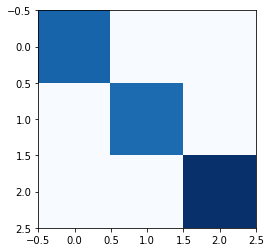

In [112]:
cm = confusion_matrix(y_test, clf_rf_pred)   
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [113]:
print(accuracy_score(y_test, clf_rf_pred))

1.0


In [133]:
#salvataggio modello per la demo
filename = 'rf_punto1.sav'
joblib.dump(clf_rf, filename)

['rf_punto1.sav']

<h3>Support Vector Machine</h3>

In [116]:
# Hyperparameters to try
param_grid_svc = {'C': [10, 50, 100, 150, 1000],
                  'gamma': [0.005, 0.001, 0.01, 0.5],
                  'kernel': ['linear', 'rbf', 'poly']}

clf_svc = GridSearchCV(SVC(class_weight='balanced'), param_grid_svc, cv=3)

clf_svc = clf_svc.fit(X_train, y_train)

In [117]:
#Best parameters
print("Migliore combinazione di parametri:")
print(" C: "+str(clf_svc.best_estimator_.C))
print(" gamma: "+str(clf_svc.best_estimator_.gamma))
print(" kernel: "+str(clf_svc.best_estimator_.kernel))

Best parameters:
 C: 10
 gamma: 0.005
 kernel: linear


In [118]:
clf_svc_pred = clf_svc.predict(X_test)

In [119]:
print(classification_report(y_test, clf_svc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        35

   micro avg       1.00      1.00      1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



[[28  0  0]
 [ 0 27  0]
 [ 0  0 35]]


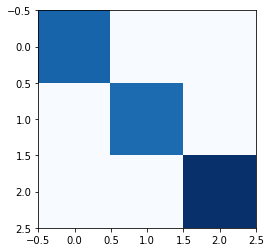

In [120]:
cm = confusion_matrix(y_test, clf_svc_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [121]:
print(accuracy_score(y_test, clf_svc_pred))

1.0


<h3>Neural network</h3>

In [122]:
np.shape(X_train)

(210, 8625)

In [127]:
def NN_model(optimizer='adam', activation_layer_1 ='softmax',activation_layer_2 ='softmax', activation_last_layer = 'softmax',  neurons = 1, dropout_rate_1 = 0.0, dropout_rate_2 = 0.0):

    modello= Sequential()
    modello.add(Dense(neurons, activation='relu', input_shape=(8625,)))
    modello.add(Dropout(dropout_rate_1))
    modello.add(Dense(neurons, activation=activation_layer_1))
    modello.add(Dropout(dropout_rate_2))
    modello.add(Dense(neurons, activation=activation_layer_2))
    modello.add(Dense(3, activation = activation_last_layer))
    modello.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    return(modello)

In [128]:
modello_per_random_search = KerasClassifier(build_fn=NN_model, verbose = 0)
batch_size = [10,25,50]
epochs = [3,5,10]
optimizer = ['Adadelta', 'Adam']
activation_layer_1 = ['softmax','relu', 'sigmoid', 'tanh']
activation_layer_2 = ['softmax','relu', 'sigmoid', 'tanh']
activation_last_layer = ['softmax','relu', 'sigmoid', 'tanh']
neurons = [256,512,1024]
dropout_rate_1 = [0.0, 0.1, 0.2,0.4,0.6,0.8]
dropout_rate_2 = [0.0, 0.1, 0.2,0.4,0.6,0.8]
param_distributions = dict(batch_size=batch_size, epochs=epochs,optimizer = optimizer,
                           dropout_rate_1 = dropout_rate_1,
                           dropout_rate_2 = dropout_rate_2,
                           activation_layer_1=activation_layer_1, 
                           activation_layer_2=activation_layer_2,
                           neurons = neurons,
                           activation_last_layer = activation_last_layer)

random_search = RandomizedSearchCV(estimator=modello_per_random_search, param_distributions=param_distributions, n_iter=5)
network_history = random_search.fit(X_train, y_train)

In [129]:
network_history.best_params_

{'optimizer': 'Adam',
 'neurons': 512,
 'epochs': 3,
 'dropout_rate_2': 0.6,
 'dropout_rate_1': 0.4,
 'batch_size': 10,
 'activation_layer_2': 'tanh',
 'activation_layer_1': 'sigmoid',
 'activation_last_layer': 'sigmoid'}

In [130]:
predictions = network_history.predict(X_test)

[[28  0  0]
 [ 0 27  0]
 [ 0  0 35]]


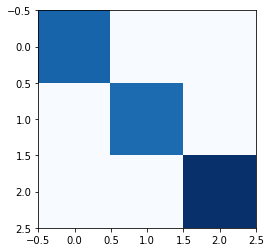

In [131]:
cm = confusion_matrix(y_test, predictions)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [132]:
print(accuracy_score(y_test, predictions))

1.0
